In [1]:
%matplotlib inline


## Training a Classifier

### This is it. You have seen how to define neural networks, compute loss and make updates to the weights of the network.

### For this tutorial, we will use the CIFAR-10 dataset. It has ten classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

## Training an image classifier

### We will do the following steps in order:

#### 1. Load and normalize the CIFAR10 training and test datasets using ``torchvision``
#### 2. Define a Convolutional Neural Network
#### 3. Define a loss function
#### 4. Train the network on the training data
#### 5. Test the network on the test data


## And now, 1. Load and normalize CIFAR10

#### Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


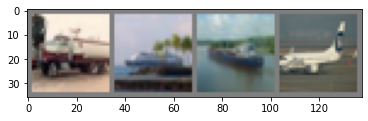

truck  ship  ship plane


In [7]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

## 2. Define a Convolutional Neural Network

### Copy the neural network from the Neural Networks section before and modify it to take 3-channel images (instead of 1-channel images as it was defined).



In [8]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## 3. Define a Loss function and optimizer
### Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4. Train the network

### This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.



In [9]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.212
[1,  4000] loss: 1.902
[1,  6000] loss: 1.698
[1,  8000] loss: 1.610
[1, 10000] loss: 1.553
[1, 12000] loss: 1.471
[2,  2000] loss: 1.402
[2,  4000] loss: 1.379
[2,  6000] loss: 1.332
[2,  8000] loss: 1.317
[2, 10000] loss: 1.303
[2, 12000] loss: 1.278
Finished Training


### Trained Models can be eaily saved and then restored later on in your code


In [10]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## 5. Test the network on the test data

### We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

### We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions. Okay, first step. Let us display an image from the test set to get familiar.



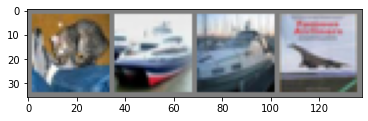

GroundTruth:    cat  ship  ship plane


In [11]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

### Next, let's load back in our saved model (note: saving and re-loading the model wasn't necessary here, we only did it to illustrate how to do so):



In [12]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

### Okay, now let us see what the neural network thinks these examples above are:



In [13]:
outputs = net(images)

### The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let's get the index of the highest energy:



In [14]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship   car  ship


## 6. Now Let's look at the training of the same network on the GPU



In [10]:
net = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)
print(device)

cuda:0


In [11]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.306
[1,  4000] loss: 2.306
[1,  6000] loss: 2.305
[1,  8000] loss: 2.307
[1, 10000] loss: 2.307
[1, 12000] loss: 2.306
[2,  2000] loss: 2.306
[2,  4000] loss: 2.307
[2,  6000] loss: 2.306
[2,  8000] loss: 2.306
[2, 10000] loss: 2.306
[2, 12000] loss: 2.304
Finished Training
